In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# warnings.filterwarnings('ignore')
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.width', 1000)

In [3]:
samples = pd.read_excel('../data/samples.xlsx', sheet_name=None)

colonnes_a_supprimer = [
    'CODTYPPRS', 'CRTOD_CMT_PRO_IND_0209', 'CRTOP_AG_IND_0038', 'CRTOP_IND_0038',
    'CRTOU_CCT_PRO_IND_0209', 'DATCREENT', 'DATRLNORG', 'RATIO1', 'RATIO3',
    'TOP_PRO_ACTIF', 'IND_ACTIF', 'IND_PER_PM', 'CODCMNIEE', 'CODPAY_NAISSANCE',
    'CODPAY_NATIONALITE', 'CODPAY_RESIDENCE', 'CODSEXPRS', 'secteur_activite',
    'secteur_activite_bis', 'INDPARDCD'
]

train, test, oot = (samples[sheet].drop(columns=colonnes_a_supprimer) for sheet in samples.keys())
sample = pd.concat([train, test, oot], ignore_index=True)

for df in [sample, train, test, oot]:
    df['datdelhis'] = (df['datdelhis'] % 100).astype(str)

CODNAF2

cluster
2    9
0    2
1    1
Name: count, dtype: int64
  CODNAF2                               CODNAF2_grouped_name  DDefaut_NDB
0   6920Z                                        6920Z-8423Z            0
1   7022Z  6202A-6621Z-6622Z-6910Z-7021Z-7022Z-7111Z-7112...            0
2   7022Z  6202A-6621Z-6622Z-6910Z-7021Z-7022Z-7111Z-7112...            0
3   7022Z  6202A-6621Z-6622Z-6910Z-7021Z-7022Z-7111Z-7112...            0
4   6202A  6202A-6621Z-6622Z-6910Z-7021Z-7022Z-7111Z-7112...            0


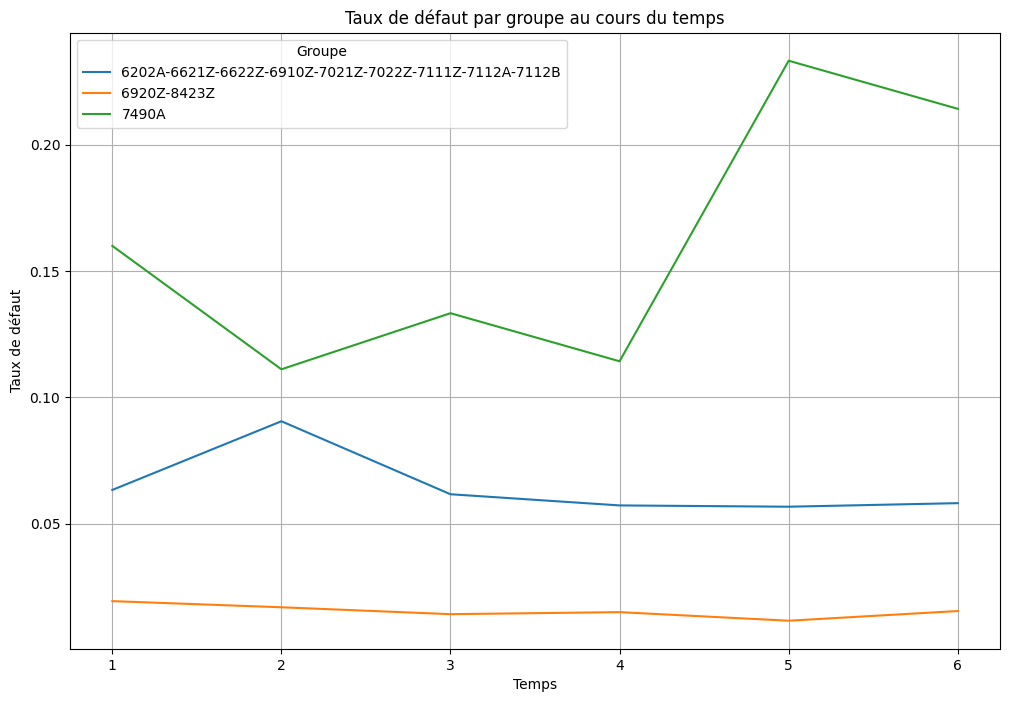

CODNAF2_grouped_name
6202A-6621Z-6622Z-6910Z-7021Z-7022Z-7111Z-7112A-7112B    0.064184
6920Z-8423Z                                              0.024540
7490A                                                    0.162651
Name: DDefaut_NDB, dtype: float64
  CODNAF2                               CODNAF2_grouped_name
0   6920Z                                        6920Z-8423Z
1   7022Z  6202A-6621Z-6622Z-6910Z-7021Z-7022Z-7111Z-7112...
2   7022Z  6202A-6621Z-6622Z-6910Z-7021Z-7022Z-7111Z-7112...
3   7022Z  6202A-6621Z-6622Z-6910Z-7021Z-7022Z-7111Z-7112...
4   6202A  6202A-6621Z-6622Z-6910Z-7021Z-7022Z-7111Z-7112...


In [4]:
# Calculer le taux de défaut pour chaque modalité et chaque période (datdelhis)
taux_defaut_temps = train.groupby(["CODNAF2", "datdelhis"])["DDefaut_NDB"].mean().reset_index()
taux_defaut_temps.columns = ["CODNAF2", "datdelhis", "taux_defaut"]

pivot_data = taux_defaut_temps.pivot(index="CODNAF2", columns="datdelhis", values="taux_defaut").fillna(0)
pivot_data = pivot_data.reset_index()

# Normalisation des données 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_data.drop(columns=["CODNAF2"]))  # Ne pas normaliser 'CODNAF2'

# Clustering avec KMeans basé sur les courbes de taux de défaut dans le temps
n_clusters = 3  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pivot_data["cluster"] = kmeans.fit_predict(scaled_data)

print(pivot_data["cluster"].value_counts())

group_names = pivot_data.groupby("cluster")["CODNAF2"].apply(lambda x: "-".join(x.sort_values())).reset_index()
group_names.columns = ["cluster", "group_name"]

group_mapping_correct = {}
for cluster, group_name in group_names.values:
    for codnaf in group_name.split('-'):  
        group_mapping_correct[codnaf] = group_name

train["CODNAF2_grouped_name"] = train["CODNAF2"].map(lambda x: group_mapping_correct.get(x, "Unknown"))

print(train[["CODNAF2", "CODNAF2_grouped_name", "DDefaut_NDB"]].head())

taux_defaut_temps["group_name"] = taux_defaut_temps["CODNAF2"].map(lambda x: group_mapping_correct.get(x, "Unknown"))

plt.figure(figsize=(12, 8))
sns.lineplot(x="datdelhis", y="taux_defaut", hue="group_name", data=taux_defaut_temps, palette="tab10", ci=None)
plt.title("Taux de défaut par groupe au cours du temps")
plt.xlabel("Temps")
plt.ylabel("Taux de défaut")
plt.grid(True)
plt.legend(title="Groupe")
plt.show()

print(train.groupby("CODNAF2_grouped_name")["DDefaut_NDB"].mean())
sample["CODNAF2_grouped_name"] = sample["CODNAF2"].map(lambda x: group_mapping_correct.get(x, "Unknown"))
print(sample[["CODNAF2", "CODNAF2_grouped_name"]].head())

Critère 1: Vérification du taux croissant entre les modalités
Critère 2: Vérification de la stabilité des modalités en taux et volumétrie
Critère 3 : Effectif minimum de 5% par modalité
Critère 4: Vérification de la séparation d'au moins 30% relatif en termes de taux de variable cible

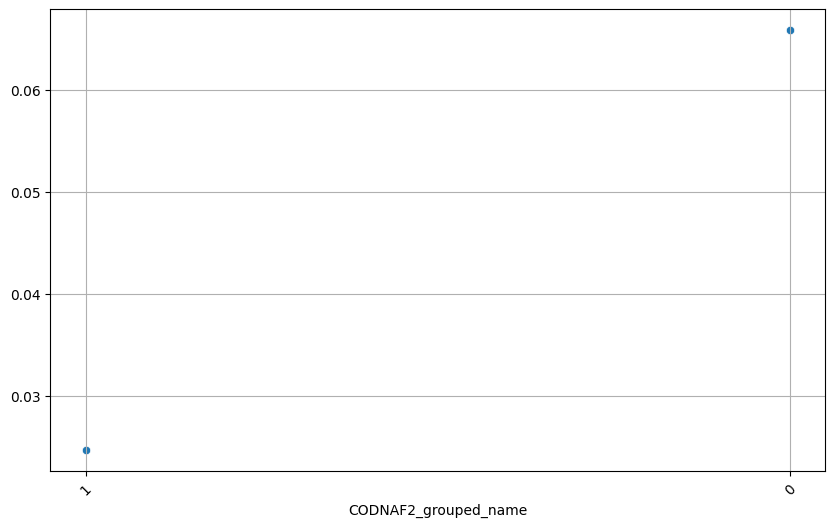

Critère 1 : Croissant


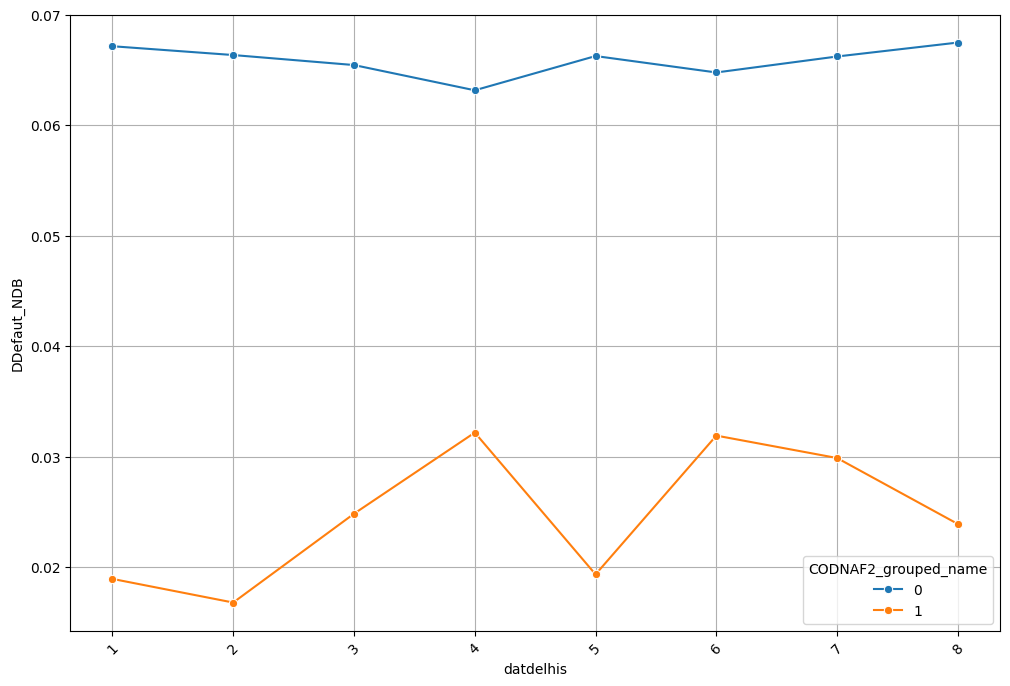

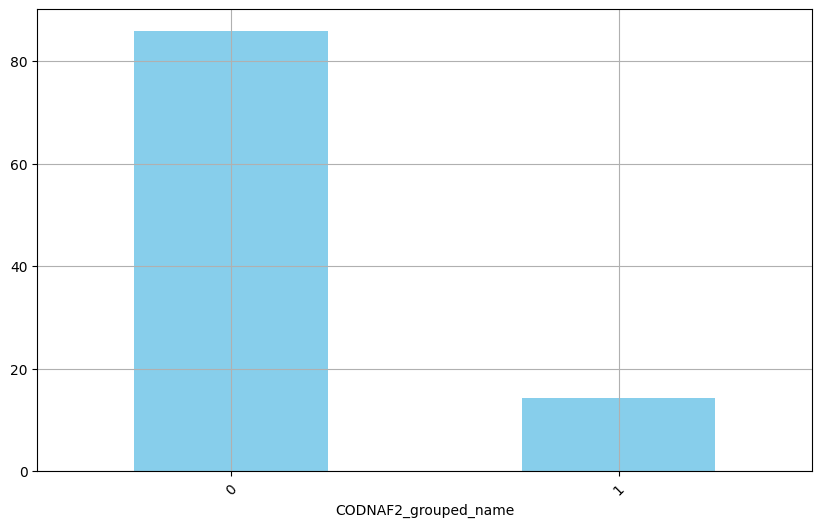

Critère 3 : Toutes à 5% ou plus


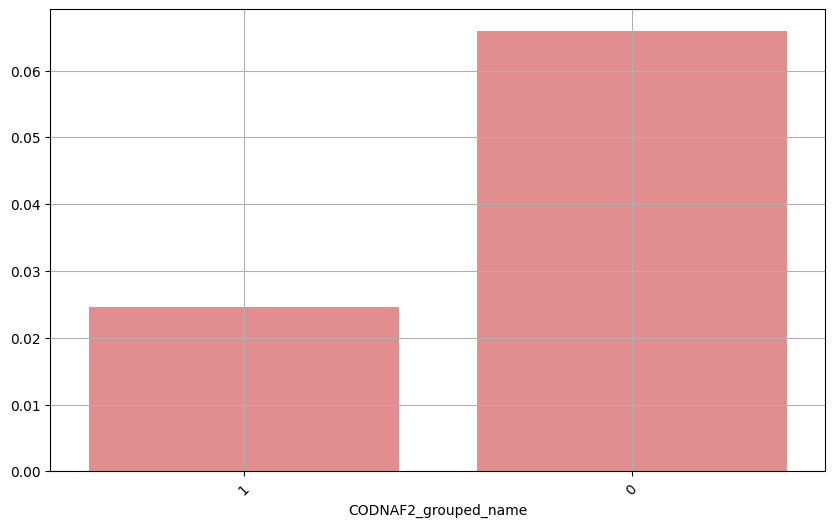

Critère 4 : 62.55% de séparation OK


In [8]:
def f():

    # Taux moyen par modalité
    taux_criteres = sample.groupby("CODNAF2_grouped_name")["DDefaut_NDB"].mean().sort_values()
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=taux_criteres.index, y=taux_criteres.values, marker='o')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    print("Critère 1 :", "Croissant" if taux_criteres.is_monotonic_increasing else "Non croissant")

    # Taux de défaut par modalité et temps
    taux_defaut_temps = sample.groupby(["CODNAF2_grouped_name", "datdelhis"])["DDefaut_NDB"].mean().reset_index()
    plt.figure(figsize=(12, 8))
    sns.lineplot(x="datdelhis", y="DDefaut_NDB", hue="CODNAF2_grouped_name", data=taux_defaut_temps, ci=None, marker='o')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

    # Distribution des effectifs
    modalites_count = sample["CODNAF2_grouped_name"].value_counts(normalize=True) * 100
    plt.figure(figsize=(10, 6))
    modalites_count.plot(kind="bar", color="skyblue")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    print("Critère 3 :", "Toutes à 5% ou plus" if (modalites_count >= 5).all() else "Certaines sous 5%")

    # Différence maximale des taux
    taux_diff = taux_criteres.max() - taux_criteres.min()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=taux_criteres.index, y=taux_criteres.values, color="lightcoral")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    separation = taux_diff / taux_criteres.max()
    print(f"Critère 4 : {separation * 100:.2f}% de séparation", "OK" if separation >= 0.3 else "Insuffisant")

f()

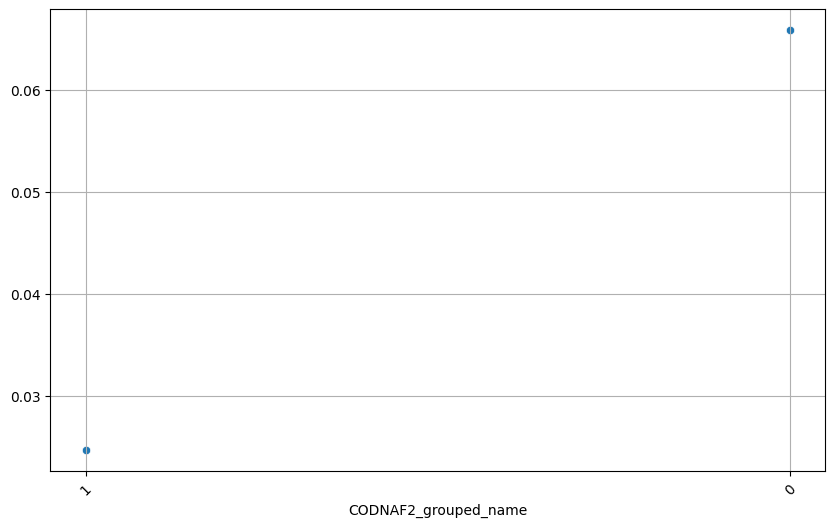

Critère 1 : Croissant


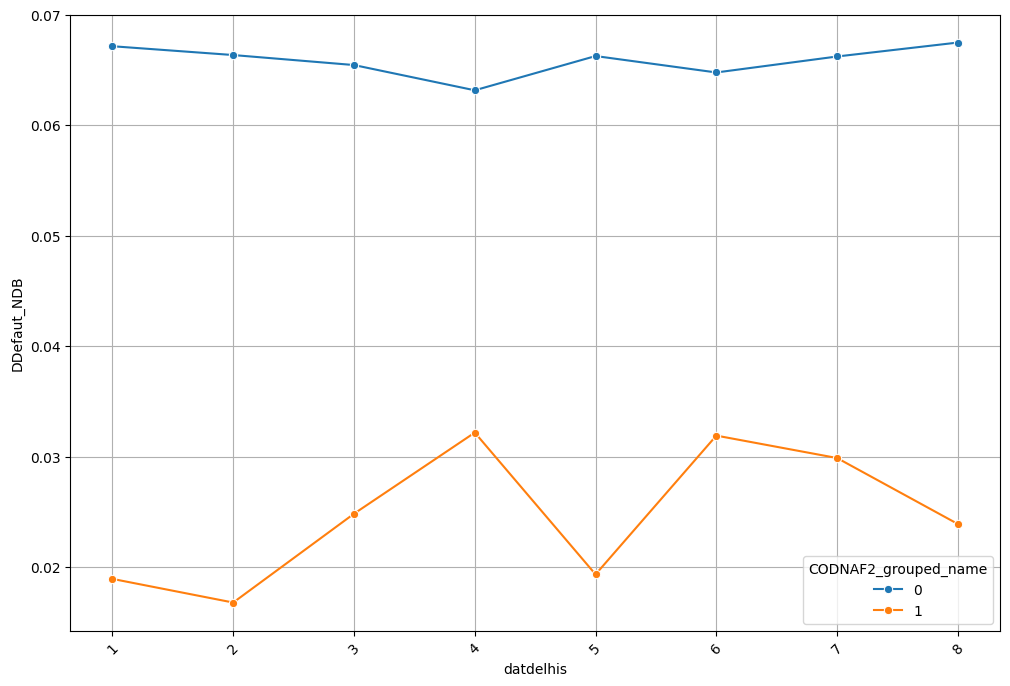

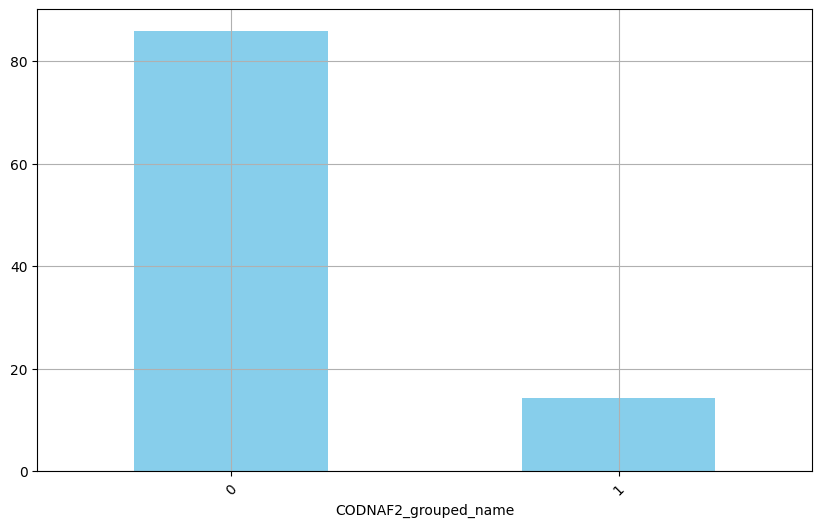

Critère 3 : Toutes à 5% ou plus


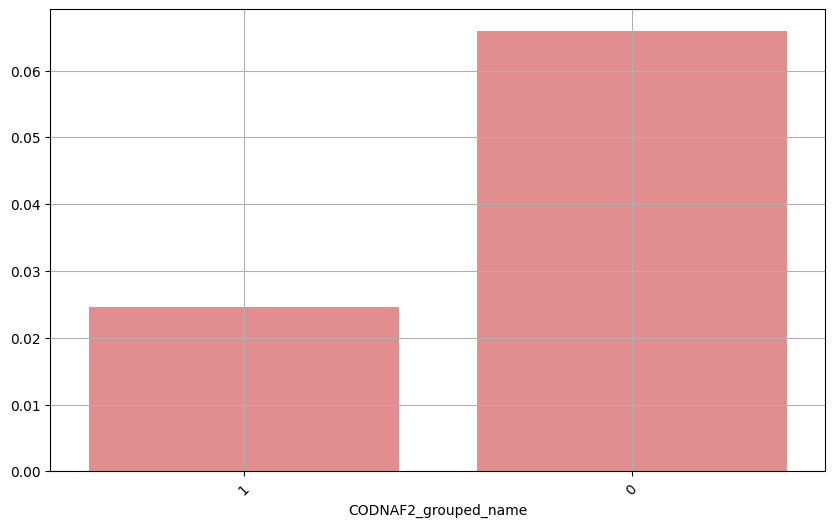

Critère 4 : 62.55% de séparation OK


In [9]:
# Regroupement des modalités
sample['CODNAF2_grouped_name'] = sample['CODNAF2_grouped_name'].replace({
    '7490A': '0',
    '6202A-6621Z-6622Z-6910Z-7021Z-7022Z-7111Z-7112A-7112B': '0',
    '6920Z-8423Z': '1'
})

sample['CODNAF2_Cat'] = sample['CODNAF2_grouped_name']
# print(sample['CODNAF2_Cat'].values)

#On relance le code avec les regroupements:
f()

CODETAJUR

on prend les 2 premiers chiffres du code

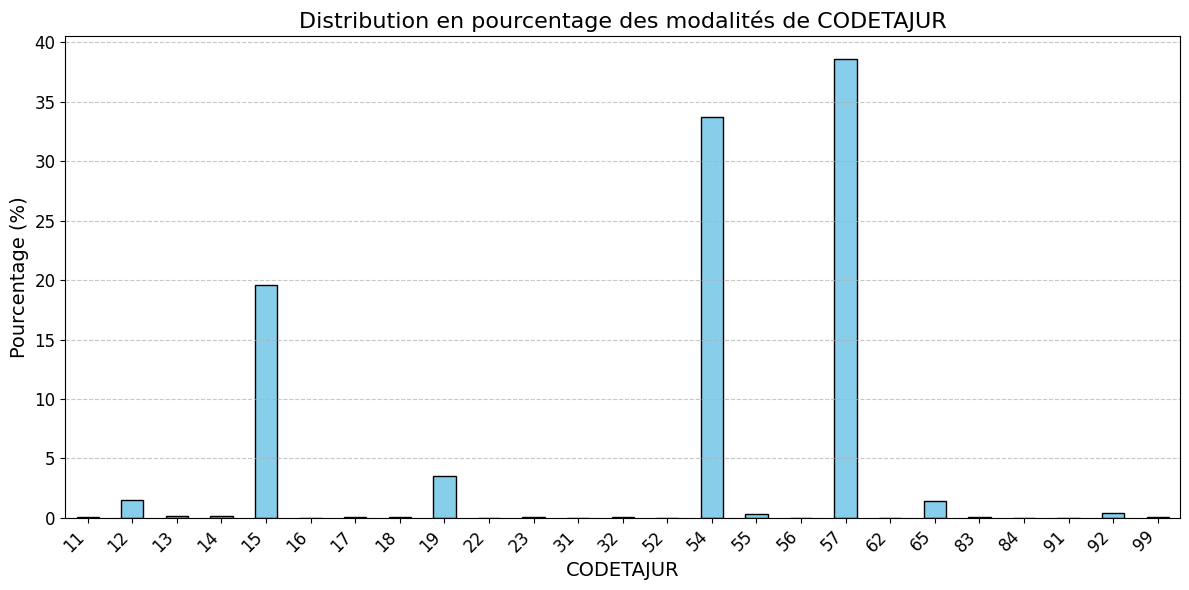

In [10]:
# Convertir CODETAJUR en chaîne et créer une nouvelle variable CODETAJUR_Cat
train['CODETAJUR'] = train['CODETAJUR'].astype(str)
train['CODETAJUR_Cat'] = train['CODETAJUR'].str[:2]

# Calculer les pourcentages des modalités de CODETAJUR_Cat
code_counts = train['CODETAJUR_Cat'].value_counts(normalize=True) * 100

# Diagramme en barres pour la distribution des modalités
plt.figure(figsize=(12, 6))
code_counts.sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

# Titres et labels
plt.title('Distribution en pourcentage des modalités de CODETAJUR', fontsize=16)
plt.xlabel('CODETAJUR', fontsize=14)
plt.ylabel('Pourcentage (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage
plt.tight_layout()
plt.show()

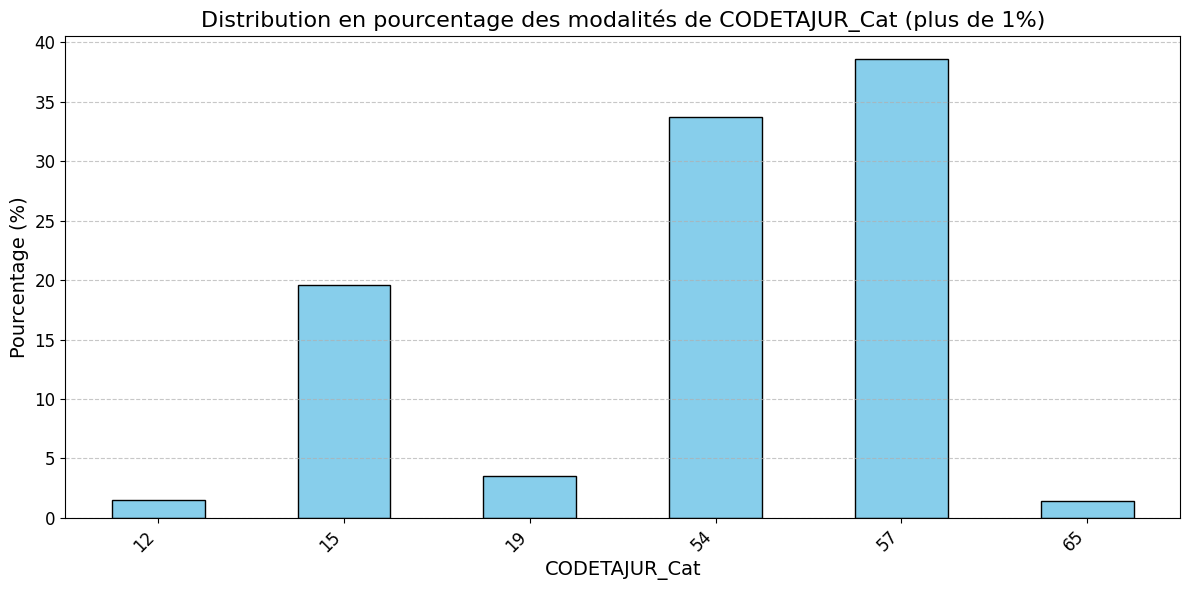

In [11]:
train['CODETAJUR_Cat'] = train['CODETAJUR'].astype(str).str[:2]
code_counts = train['CODETAJUR_Cat'].value_counts(normalize=True) * 100
code_counts[code_counts > 1].sort_index().plot(kind='bar', color='skyblue', edgecolor='black', figsize=(12, 6))
plt.title('Distribution en pourcentage des modalités de CODETAJUR_Cat (plus de 1%)', fontsize=16)
plt.xlabel('CODETAJUR_Cat', fontsize=14)
plt.ylabel('Pourcentage (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

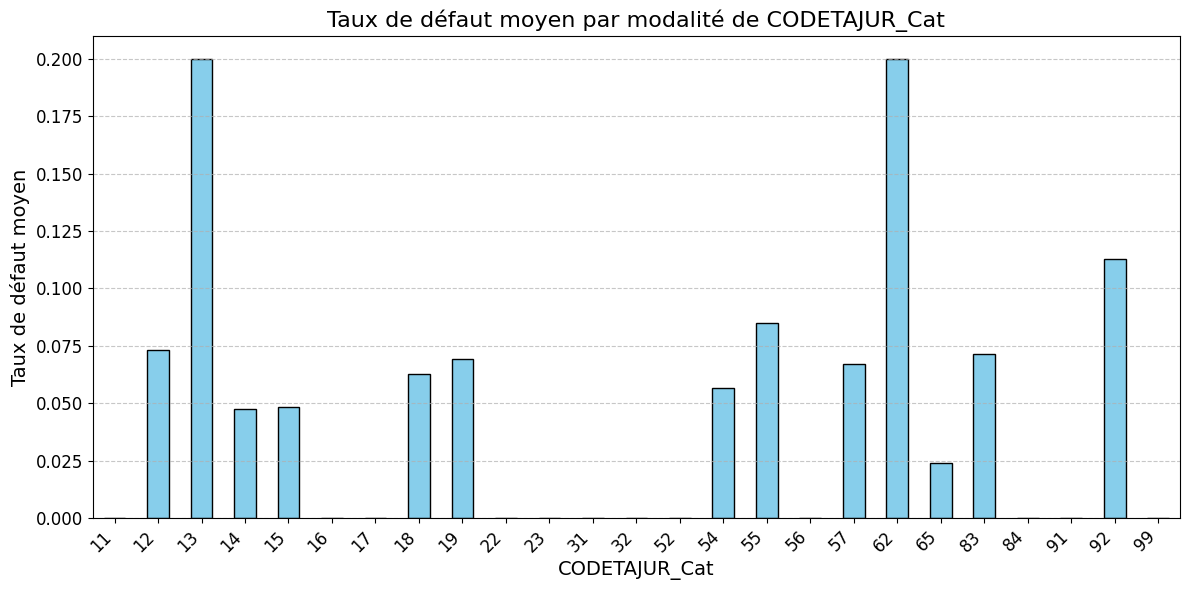

In [12]:
train['CODETAJUR_Cat'] = train['CODETAJUR'].astype(str).str[:2]
train.groupby('CODETAJUR_Cat')['DDefaut_NDB'].mean().plot(
    kind='bar', color='skyblue', edgecolor='black', figsize=(12, 6)
)
plt.title('Taux de défaut moyen par modalité de CODETAJUR_Cat', fontsize=16)
plt.xlabel('CODETAJUR_Cat', fontsize=14)
plt.ylabel('Taux de défaut moyen', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

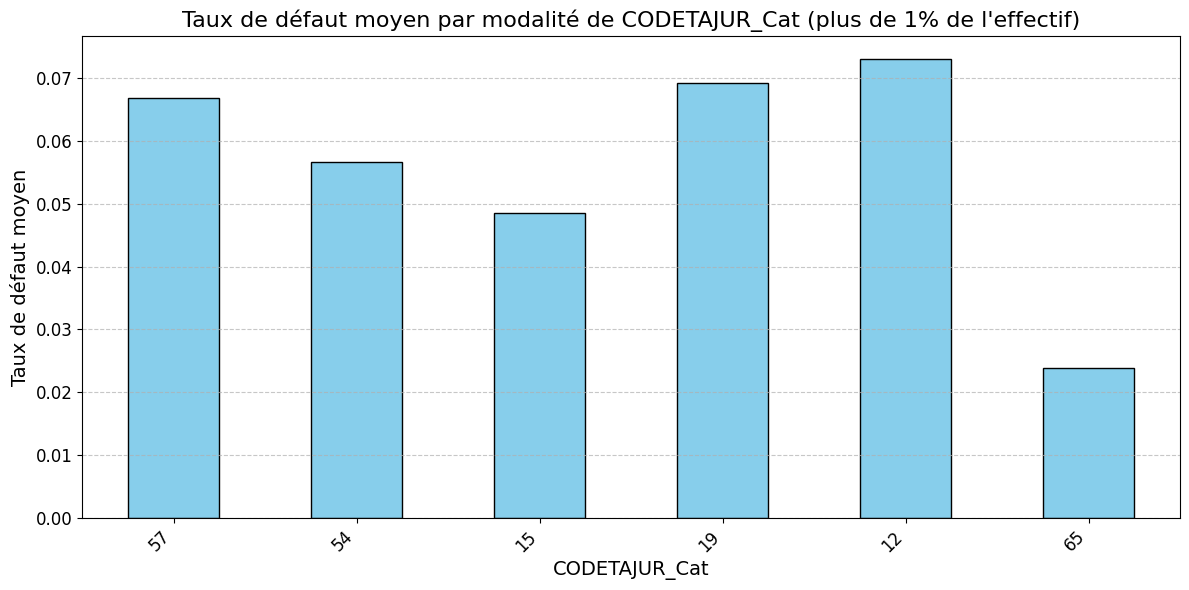

In [13]:
train['CODETAJUR_Cat'] = train['CODETAJUR'].astype(str).str[:2]
code_counts_filtered = train['CODETAJUR_Cat'].value_counts(normalize=True).loc[lambda x: x > 0.01] * 100
taux_defaut_filtered = train.groupby('CODETAJUR_Cat')['DDefaut_NDB'].mean().loc[code_counts_filtered.index]
taux_defaut_filtered.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(12, 6))
plt.title('Taux de défaut moyen par modalité de CODETAJUR_Cat (plus de 1% de l\'effectif)', fontsize=16)
plt.xlabel('CODETAJUR_Cat', fontsize=14)
plt.ylabel('Taux de défaut moyen', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
# Créer une variable CODETAJUR_Cat2 qui regroupe CODETAJUR_Cat ainsi: 0-53; 54-55, 56-57; 58-100
train['CODETAJUR_Cat2'] = train['CODETAJUR_Cat']

# Remplacer les valeurs par les plages demandées
train['CODETAJUR_Cat2'] = train['CODETAJUR_Cat2'].replace(
    ['11', '13', '14', '15', '16',
     '17', '18', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
     '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
     '49', '50', '51', '52', '53', '55', '56', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73',
     '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
     '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100'], 'Autres')
train['CODETAJUR_Cat2'] = train['CODETAJUR_Cat2'].replace(
    ['12', '19', '54', '57'], '12_19_54_57')

# Affichage du résultat
print(train[['CODETAJUR_Cat', 'CODETAJUR_Cat2']].head())
print(train['CODETAJUR_Cat2'].unique())

  CODETAJUR_Cat CODETAJUR_Cat2
0            54    12_19_54_57
1            54    12_19_54_57
2            57    12_19_54_57
3            57    12_19_54_57
4            57    12_19_54_57
['12_19_54_57' 'Autres']


Text(0, 0.5, 'Pourcentage (%)')

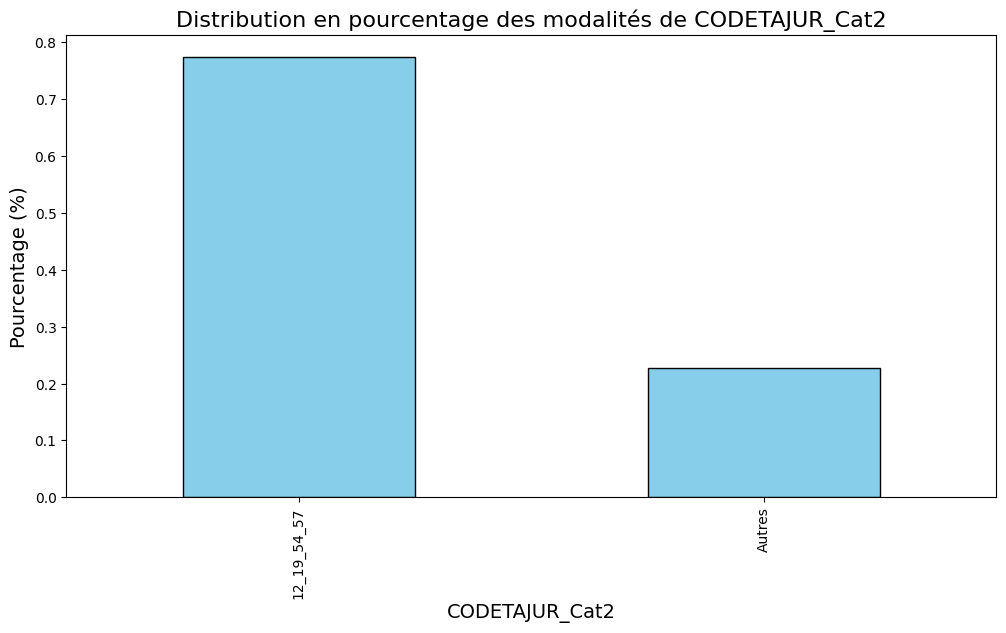

In [ ]:
# Diagramme en pourcentage
plt.figure(figsize=(12, 6))
train['CODETAJUR_Cat2'].value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution en pourcentage des modalités de CODETAJUR_Cat2', fontsize=16)
plt.xlabel('CODETAJUR_Cat2', fontsize=14)
plt.ylabel('Pourcentage (%)', fontsize=14)

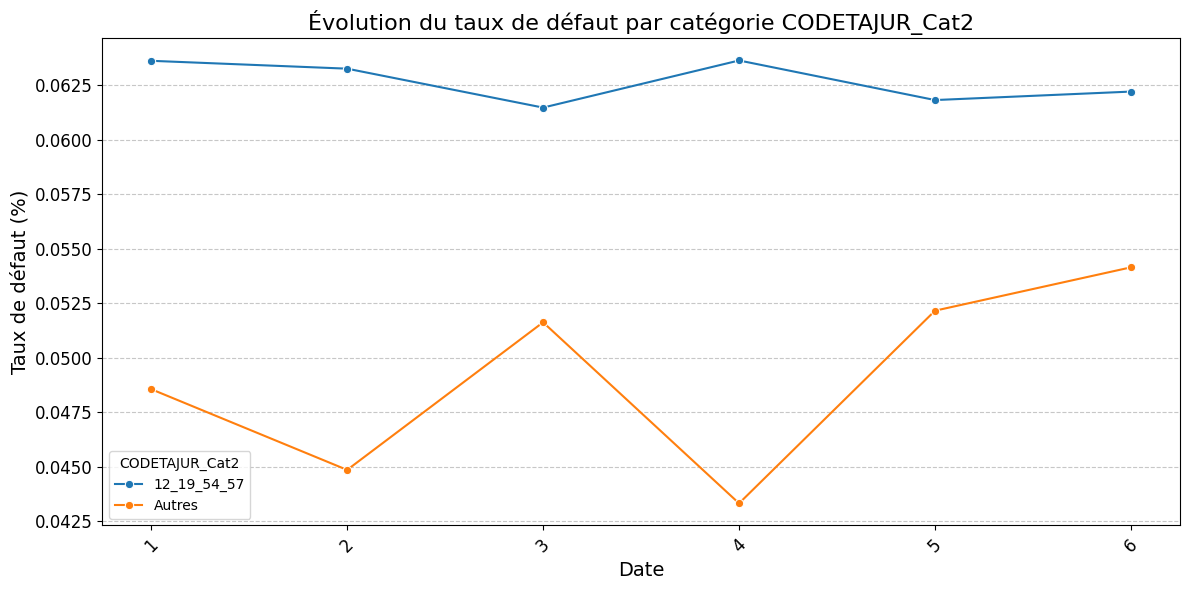

In [16]:
taux_defaut_temps = train.groupby(["CODETAJUR_Cat2", "datdelhis"])["DDefaut_NDB"].mean().reset_index()
taux_defaut_temps.columns = ["CODETAJUR_Cat2", "datdelhis", "taux_defaut"]

plt.figure(figsize=(12, 6))
sns.lineplot(data=taux_defaut_temps, x='datdelhis', y='taux_defaut', hue='CODETAJUR_Cat2', marker='o')
plt.title('Évolution du taux de défaut par catégorie CODETAJUR_Cat2', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Taux de défaut (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

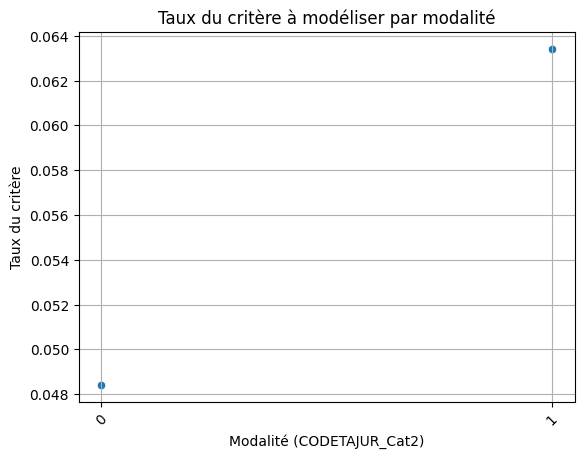

Critère 1 : Le taux du critère est croissant entre les modalités.


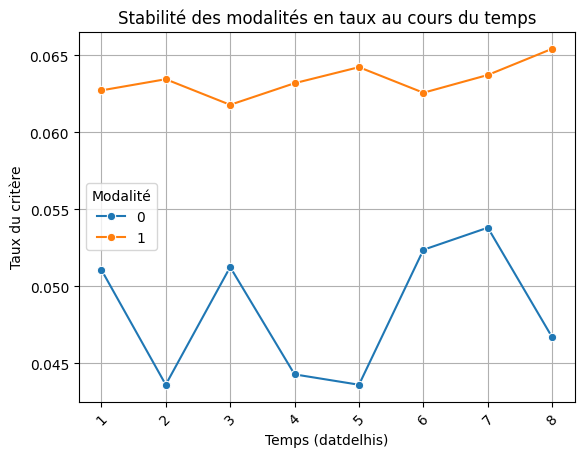

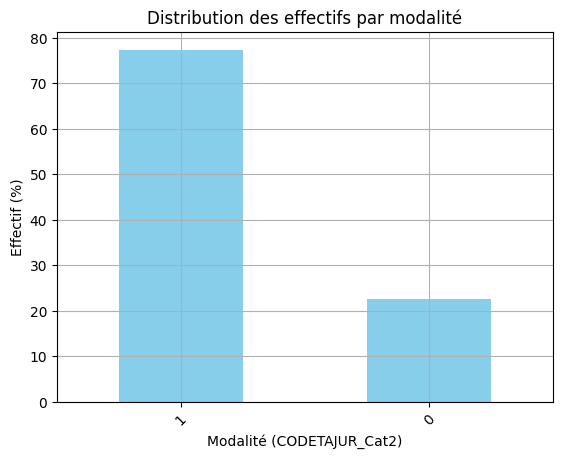

Critère 3 : Toutes les modalités ont un effectif supérieur ou égal à 5%.


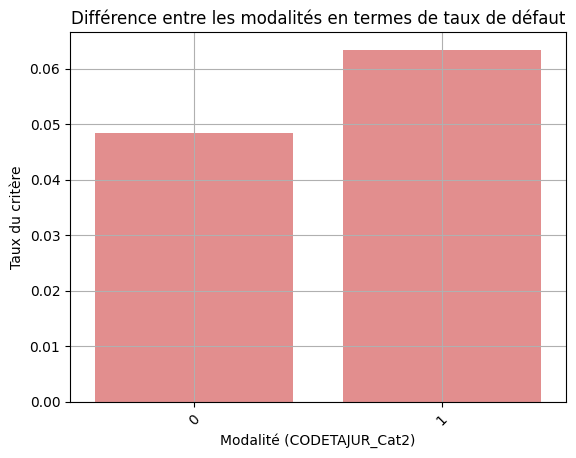

Critère 4 : Les modalités ne sont pas séparées d'au moins 30% en termes de taux de défaut. (Séparation: 0.24)


In [17]:
# Conversion et remplacement des valeurs dans CODETAJUR_Cat2
sample['CODETAJUR_Cat2'] = sample['CODETAJUR'].astype(str).str[:2].replace(
    {**{str(i): '0' for i in range(11, 101) if i not in [12, 19, 54, 57]}, 
     '12': '1', '19': '1', '54': '1', '57': '1'}
)

# Critère 1: Vérification du taux croissant entre les modalités
taux_criteres = sample.groupby("CODETAJUR_Cat2")["DDefaut_NDB"].mean().sort_values()
sns.scatterplot(x=taux_criteres.index, y=taux_criteres.values, marker='o')
plt.title("Taux du critère à modéliser par modalité")
plt.xlabel("Modalité (CODETAJUR_Cat2)")
plt.ylabel("Taux du critère")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Vérification du critère 1 : Croissant entre les modalités
print(f"Critère 1 : Le taux du critère est {'croissant' if taux_criteres.is_monotonic_increasing else 'non croissant'} entre les modalités.")

# Critère 2: Vérification de la stabilité des modalités en taux et volumétrie
taux_defaut_temps = sample.groupby(["CODETAJUR_Cat2", "datdelhis"])["DDefaut_NDB"].mean().reset_index()
sns.lineplot(x="datdelhis", y="DDefaut_NDB", hue="CODETAJUR_Cat2", data=taux_defaut_temps, ci=None, marker='o')
plt.title("Stabilité des modalités en taux au cours du temps")
plt.xlabel("Temps (datdelhis)")
plt.ylabel("Taux du critère")
plt.grid(True)
plt.legend(title="Modalité")
plt.xticks(rotation=45)
plt.show()

# Vérification de la stabilité en volumétrie : effectif minimum de 5%
modalites_count = sample["CODETAJUR_Cat2"].value_counts(normalize=True) * 100
modalites_count.plot(kind="bar", color="skyblue")
plt.title("Distribution des effectifs par modalité")
plt.xlabel("Modalité (CODETAJUR_Cat2)")
plt.ylabel("Effectif (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Vérification du critère 3 : Effectif minimum de 5% par modalité
modalites_filtres = modalites_count[modalites_count >= 5]
print(f"Critère 3 : Toutes les modalités ont un effectif supérieur ou égal à 5%." if len(modalites_filtres) == len(modalites_count)
      else f"Critère 3 : Certaines modalités ont un effectif inférieur à 5%.")

# Critère 4: Vérification de la séparation d'au moins 30% relatif en termes de taux de variable cible
max_diff = taux_criteres.max() - taux_criteres.min()
sns.barplot(x=taux_criteres.index, y=taux_criteres.values, color="lightcoral")
plt.title("Différence entre les modalités en termes de taux de défaut")
plt.xlabel("Modalité (CODETAJUR_Cat2)")
plt.ylabel("Taux du critère")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Vérification du critère 4 : Séparation de 30% relatif
separation = max_diff / taux_criteres.max()
print(f"Critère 4 : Les modalités sont séparées d'au moins 30% en termes de taux de défaut." if separation >= 0.30
      else f"Critère 4 : Les modalités ne sont pas séparées d'au moins 30% en termes de taux de défaut. (Séparation: {separation:.2f})")

CODITDBDF_PRO:

Binaire (0 ou 2). La catégorie 2 à un effectif inférieur a 5%. On ne garde pas cette variable

AGEPRS: Elle a été supprimé lors des test de significativité des variables quantitatives. Cependant on avait initialement pas pris la variable personne morale/physique car l'information etait inclu dans AGEPRS. On test donc ici cette telle variable pour etre sur de ne pas passer a coté d'informations.

In [18]:
# 0 et non 0
labels = ['0', 'non 0']
bins = [0, 1, 100]

# Créer une nouvelle colonne 'AGEPRS_CAT' qui contient les classes
train['AGEPRS_CAT'] = pd.cut(train['AGEPRS'], bins=bins, labels=labels, right=False)
sample['AGEPRS_CAT'] = pd.cut(sample['AGEPRS'], bins=bins, labels=labels, right=False)

# Afficher le dataframe avec la nouvelle colonne
print(train['AGEPRS_CAT'].unique())

['0', 'non 0']
Categories (2, object): ['0' < 'non 0']


cluster
0    1
1    1
Name: count, dtype: int64
  AGEPRS_CAT AGEPRS_CAT_grouped_name  DDefaut_NDB
0          0                       0            0
1          0                       0            0
2          0                       0            0
3          0                       0            0
4          0                       0            0


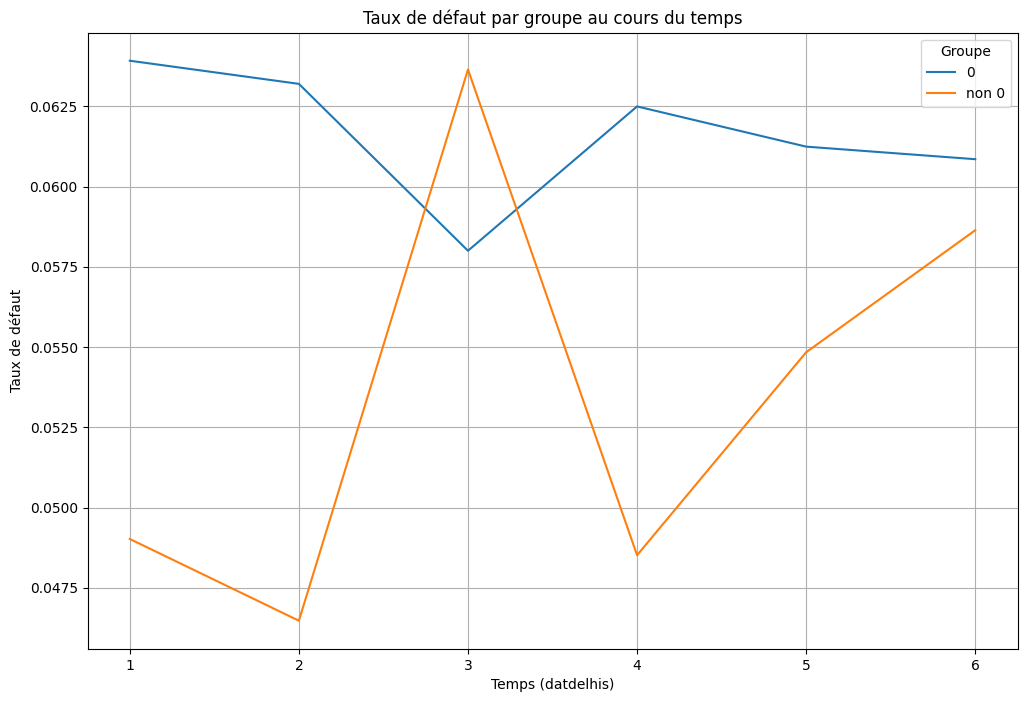

AGEPRS_CAT_grouped_name
0        0.061610
non 0    0.053557
Name: DDefaut_NDB, dtype: float64
  AGEPRS_CAT AGEPRS_CAT_grouped_name
0          0                       0
1          0                       0
2          0                       0
3          0                       0
4          0                       0


In [22]:


# Calculer le taux de défaut pour chaque modalité et chaque période (datdelhis)
taux_defaut_temps = train.groupby(["AGEPRS_CAT", "datdelhis"])["DDefaut_NDB"].mean().reset_index()
taux_defaut_temps.columns = ["AGEPRS_CAT", "datdelhis", "taux_defaut"]

# Pivot pour obtenir une table où chaque ligne est une modalité et chaque colonne est une période
pivot_data = taux_defaut_temps.pivot(index="AGEPRS_CAT", columns="datdelhis", values="taux_defaut").fillna(0)

# Réinitialiser l'index pour que 'CODNAF2' soit une colonne
pivot_data = pivot_data.reset_index()

# Normalisation des données pour éviter les biais dus aux échelles différentes
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_data.drop(columns=["AGEPRS_CAT"]))  # Ne pas normaliser 'CODNAF2'

# Clustering avec KMeans basé sur les courbes de taux de défaut dans le temps
n_clusters = 2  # Vous pouvez ajuster ce paramètre
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pivot_data["cluster"] = kmeans.fit_predict(scaled_data)

# Afficher les clusters pour chaque modalité
print(pivot_data["cluster"].value_counts())

# Créer un nom de groupe sous forme 'modalité1-modalité2...'
group_names = pivot_data.groupby("cluster")["AGEPRS_CAT"].apply(lambda x: "_".join(x.sort_values())).reset_index()
group_names.columns = ["cluster", "group_name"]

# Créer un mappage correct entre chaque modalité de CODNAF2 et son groupe
group_mapping_correct = {}
for cluster, group_name in group_names.values:
    for codnaf in group_name.split('_'):  # Divisez les groupes concaténés par '_'
        group_mapping_correct[codnaf] = group_name

# Appliquer le mappage à 'train'
train["AGEPRS_CAT_grouped_name"] = train["AGEPRS_CAT"].map(lambda x: group_mapping_correct.get(x, "Unknown"))

# Vérification : afficher les regroupements dans le DataFrame original avec les noms des groupes
print(train[["AGEPRS_CAT", "AGEPRS_CAT_grouped_name", "DDefaut_NDB"]].head())

# Visualisation : tracer les courbes de taux de défaut par groupe
taux_defaut_temps["group_name"] = taux_defaut_temps["AGEPRS_CAT"].map(lambda x: group_mapping_correct.get(x, "Unknown"))

plt.figure(figsize=(12, 8))

# Tracer les courbes pour chaque groupe sans les intervalles de confiance
sns.lineplot(x="datdelhis", y="taux_defaut", hue="group_name", data=taux_defaut_temps, palette="tab10", ci=None)

# Ajouter des informations
plt.title("Taux de défaut par groupe au cours du temps")
plt.xlabel("Temps (datdelhis)")
plt.ylabel("Taux de défaut")
plt.grid(True)
plt.legend(title="Groupe")
plt.show()

# Évaluer la pertinence des groupes : vérifier que les groupes sont bien séparés
print(train.groupby("AGEPRS_CAT_grouped_name")["DDefaut_NDB"].mean())

# Ajouter la variable 'CODNAF2_grouped_name' dans 'sample' en utilisant le même mappage
sample["AGEPRS_CAT_grouped_name"] = sample["AGEPRS_CAT"].map(lambda x: group_mapping_correct.get(x, "Unknown"))

# Vérification : afficher les résultats pour un échantillon de 'sample'
print(sample[["AGEPRS_CAT", "AGEPRS_CAT_grouped_name"]].head())


In [22]:
quali_discretized_sample = sample[['id_client', 'DDefaut_NDB', 'datdelhis', 'CODNAF2_Cat', 'CODETAJUR_Cat2']]
quali_discretized_sample = quali_discretized_sample.rename(columns={'CODNAF2_Cat': 'CODNAF2', 'CODETAJUR_Cat2': 'CODETAJUR'})
quali_discretized_sample.head(100)

,id_client,DDefaut_NDB,datdelhis,CODNAF2,CODETAJUR
0,6002959649,0,5,1,1
1,3235248704,0,1,0,1
2,7995781136,0,3,0,1
3,2112452922,0,5,0,1
4,3540500580,0,2,0,1
5,8390775990,0,6,0,1
6,1528496440,0,3,0,1
7,3019876475,0,2,0,1
8,1500330744,0,3,0,1
9,3549117482,0,2,0,1


In [23]:
quali_discretized_sample.to_excel('../data/quali_discretized_sample.xlsx', index=True)